# Análise Geométrica em Julia

Nesse capítulo iremos mostrar como podemos realizar análises geométricas utilizando Julia.
De maneira mais específica, vamos mostrar como trabalhar com Manifolds (variedades) e malhas.
Um Manifold generaliza nossa intuição de objetos geométricos, enquanto malhas são muito utilizadas
como uma maneira de representar de forma aproximada um objeto geométrico.

Julia possui os pacotes Manifolds.jl e ManifoldsBase.jl que nos permitem trabalhar de forma abstrata com Manifolds
sem nos preocupar em definir toda a estrutura de dados necessária. Para malhas, utilizaremos
o pacote Meshes.jl.

O conteúdo se baseia neste curso de [Shape Analysis](https://groups.csail.mit.edu/gdpgroup/6838_spring_2021.html) ministrado
pelo professor Justin Solomon.

## 1 - Teoria Básica de Manifolds

Antes de entrar no código, vamos fazer uma breve revisão dos conceitos básicos envolvendo Manifolds
(em português Manifolds são chamados de Variedades, porém, utilizaremos o termo em inglês, pois é o nome dos pacotes em Julia).
Aqui, nos baseamos principalmente no livro "Introduction to Manifolds" (Tu).

Primeiro, o que é afinal um Manifold? De forma informal, um Manifold nada mais é que a generalização do conceito de Curva, Superfície
ou "Sólidos". A primeira vista, pode parecer algo fácil de se definir, mas não é. Antes de definir formalmente um Manifold, que tipo
de objeto geométrico **não** seria um Manifold? Um bom exemplo é uma mesa. Ao modelar um objeto 3D como uma mesa, podemos ser tentados
a modelar primeiro as quatro pernas, para então "encaixá-las" sob o corpo retangular da mesa. Esse objeto construído desta forma
não seria um Manifold. Porém, se invés disso construíssemos a mesa primeira pegando um enorme toco de madeira e esculpíssemos, nesse
caso ela seria um Manifold... Ou seja, a idea de uma Manifold tem relação com a continuidade da nossa superfície, e com o fato que podemos,
por exemplo, dizer sob qual face estamos. Note que na mesa construída em partes, ao colar as pernas, estamos colando duas faces juntas.

Segundo ponto a se observar é que existem vários tipos de Manifolds. Temos os Manifolds topológicos, analíticos, complexos.
Vamos começar pelos topológicos. Para isso, enunciaremos algumas definições para refrescar a memória.

### 1.1 - Manifolds Topológicos

**Def. (Hausdorff Space)** Um espaço topológico $X$ é Hausdorff se para todo
$x,y \in X$, existem abertos $U, V \subset X$, tal que
$x \in U, y \in V$ e $U \cap V = \varnothing$.

**Def. (Base Topológica)** A base de um espaço topológico $X$ é uma família de abertos $\mathfrak B$
tal que para todo aberto $V \in X$, temos que $V$ pode ser construído como uma união arbitrária de abertos de $\mathfrak B$, ou seja,
$V = \cup_{i \in \Lambda} B_i$, onde $B_i \in \mathfrak B$ para todo $i \in \Lambda$.
Além disso, um espaço topológico $X$ é **segundamente contável** se possui uma base enumerável.

**Def. (Homeomorfismo)** Um homeomorfismo entre dois espaços topológicos $X$ e $Y$ é uma função $f:X\to Y$ bi-contínuo
(bijeção contínua com inversa contínua).

**Def. (Localmente Euclidiano)** Um espaço topológico $M$ é localmente Euclidiano se para todo $p\in M$ existe um aberto
$U$, tal que $p \in U$, e existe um homeomorfismo entre $U$ e um aberto $V \subset \mathbb R^n$ dado por $\phi: U \to V \subset \mathbb R^n$.
Chamamos o conjunto $(U, \phi:U \to \mathbb R^n)$ de carta.

Finalmente, podemos enunciar a definição do nosso Manifold topológico.

**Def. (Manifold Topológico)** Um espaço topológico $M$ é um Manifold se ele for Hausdorff, segundamente contável e localmente Euclidiano.
A dimensão de $M$ é a mesma da dimensão de $\mathbb R^n$ na qual ele é localmente Euclidiano.

----
*Exemplo - Malha Triangular*

Com essa definição, podemos nos perguntar se uma malha triangulada em 3D seria um Manifold topológico.
Essa pergunta não está bem colocada, pois precisaríamos identificar de forma mais clara como essa malha está definida.
Vamos invés disso ser pragmáticos. A malha triangular que estamos assumindo consiste de pegar um Manifold e tentar
aproximá-lo usando malhas triangulares. Assim, não estamos considerando malhas patológicas, onde, por exemplo, uma aresta
é compartilhada por mais de dois triângulo.

A resposta para isso é um sim. Para provar isso, note que o espaço $\mathbb R^3$ é Hausdorff e segundamente contável. Além disso,
como a malha triangular está dentro de $\mathbb R^3$, então ele também é Hausdorff e segundamente contável (essas propriedade são herdadas por subconjuntos).

Note que nossa malha na verdade terá dimensão 2, já que ela é uma superfície.
Devemos aqui nos atentar a um outro ponto. Nossas malhas são finitas e contém bordas nas extremidades. Assim, elas não serão homeomorfas à $\mathbb R^2$,
mas sim à $\mathbb R^2_+$ (ou seja, extensão contendo $\infty$).
Assim, queremos provar que ela é localmente Euclidiana
em relação à $\mathbb R^2_+$. É óbvio que qualquer bola aberta na face de um triângulo será homeomorfo a um aberto
em $\mathbb R^2_+$, basta tomar $\phi(x,y,z) = (x,y)$, ou seja, a projeção. Na verdade, esse mesmo $\phi$ também
funciona para caso nosso ponto esteja em um vértice ou aresta. Com isso, temos que de fato malhas (não só triangulares) são Manifolds topológicos.

----

### 1.2 - Manifolds Suaves

A idea das cartas que introduzimos na seção anterior serve como uma maneira de mapear localmente o Manifold para um espaço Euclidiano, onde
temos mais ferramental para trabalhar (sabemos calcular distâncias, produtos internos, ângulos, etc). A idéia é cobrir o Manifold com um conjunto dessa
cartas, formando o que chamamos de atlas.

**Def. ($C^\infty$-Compatibilidade de Cartas)** Dadas duas cartas $(U, \phi:U\to \mathbb R^n)$ e $(V, \psi:V \to \mathbb R^n)$
ambas $C^\infty$ e sob o mesmo Manifold topológico $M$, dizemos que elas
são $C^\infty$-compatíveis se 

$$
\phi \circ \psi^{-1} : \psi(U \cap V) \to \phi (U\cap V), \quad
\psi \circ \phi^{-1} : \phi(U \cap V) \to \psi (U\cap V)
$$

são $C^\infty$. Chamamos
$\phi\circ \psi^{-1}$ e $\psi\circ \phi^{-1}$ de funções de transição.
Note que se $U\cap V = \varnothing$, temos que elas são compatíveis por vacuidade. Além disso, como $U$ e $V$ são abertos, então $U \cap V$ é aberto.
Além disso, como $\phi$ é bi-contínua, então $\phi(U \cap V)$ é aberta, e o mesmo para $\psi(U\cap V)$ (lembre-se, uma função é contínua se
$f^{-1}(U)$ for aberto para todo $U$ aberto).


**Def. ($C^\infty$ Atlas)** Dado um espaço topológico $M$ localmente Euclidiano. Um $C^\infty$ atlas consiste numa família
$\mathfrak B$ de cartas $(U_\lambda, \phi_{\lambda})$ que são $C^\infty$ compatíveis em pares
que cobre $M$, i.e. $M = \cup_{\lambda} U_\lambda$.
Mais ainda, dizemos que uma carta $(V, \psi)$ é compatível com o atlas $\mathfrak B$ se ela for compatível com todas as cartas da família.

**Proposição** Se duas cartas $(U, \phi)$ e $(V, \psi)$ são compatíveis com $\mathfrak M$, então elas são compatíveis entre si.

**Def. (Atlas Maximal)** Dado um Manifold topológico $M$, um atlas $\mathfrak M$ é maximal se ele não estiver contido em nenhum outro
atlas de $M$. Ou seja, se para um atlas $\mathfrak B$ tivermos $\mathfrak M \subset \mathfrak B$, então $\mathfrak B = \mathfrak M$.

Antes de finalmente definirmos um Manifold suave, vamos relembrar a ideia de conexidade em topologia, pois isto será útil na hora
de definirmos a dimensão de uma Manifold.

**Def. (Espaço Conexo)** Um espaço topológico $X$ é conexo se ele só adimite cisão trivial, isto é, se os únicos conjuntos simultaneamente abertos
e fechados em $X$ são $\varnothing$ e o próprio $X$.

**Proposição** Seja $(U_\lambda)$ uma família de subconjuntos conexos de um espaço topológico $X$. Se existir
$x \in U_{\lambda}$ para todo $\lambda$, então $\cup_\lambda U_\lambda$ é conexo.

**Def. (Componente Conexa)** Dado um ponto $x \in X$, a união de todos os subconjuntos conexos que contém $x$ é chamada de
componente conexa de $x$.

**Def. (Manifold Suave)** Um Manifold suave é uma tupla $(M, \mathfrak M)$ onde $M$ é um Manifold topológico e $\mathfrak M$ é um $C^\infty$-atlas maximal.
Dizemos que $M$ tem dimensão $n$ se todas suas componentes conexas tem dimensão $n$.


**A partir de agora, sempre que falarmos "Manifold" sem nenhuma outra caracterização, estaremos então nos referindo à Manifolds suaves.**

**Teorema** Seja $M$ um Manifold topológico. Se existir um $C^\infty$-atlas $\mathfrak M$, então ele está contido em um atlas maximal.
Além disso, este atlas será único.

*DEM.* Usando a proposição de que se duas cartas são ambas compatíveis com um atlas $\mathfrak M$, então elas são ambas compatíveis,
podemos assim criar um atlas $\mathfrak M_+$ formado por $\mathfrak M$ união com todos os demais atlas compatíveis com $\mathfrak M$.
Assim, esse atlas é maximal. Além disso, se existir um outro atlas $\mathfrak M'$ maximal que contém $\mathfrak U$, então todos os seus
atlas são compatíveis com $\mathfrak U$ e assim já estão incorporados em $\mathfrak M_+$. Logo, $\mathfrak M' \subset \mathfrak M_+$
o que implica que $\mathfrak M' = \mathfrak M_+$.

Outro resultado relevante para a construção de Manifolds é que o produto cartesiano de dois Manifolds suaves também é um Manifold
suave. Com isso, é fácil mostrar que, por exemplo, um torus é um Manifold, assim como um cilindro infinito.

**Teorema**
Se $(U_i, \phi_i)$ e $(V_j, \psi_j)$ são $C^\infty$-atlas em Manifolds $M$ e $N$, cada um com dimensão $m$ e $n$ respectivamente. Então

$$
(U_i \times V_j, \phi_i \times \psi_j : U_i \times V_j \to \mathbb R^m \times \mathbb R^n)
$$

é um $C^\infty$-atlas em $M\times N$. Além disso, a dimensão de $M\times N$ é $m+n$.

*DEM.* Como $M \times N$ está em $\mathbb R^{m n}$ que é Hausdorff e segundamente contável, então essas condições já valem para $M \times N$.
Além disso, o número de componentes conexas é dado pela simples soma das componentes conexas em $M$ e $N$, assim a dimensão é $m + n$.
A condição de localmente Euclidiano também é válida para $M \times N$, já que como $M$ e $N$ são localmente Euclidianas, então
existem os homeomorfismo $f$ e $g$, e $f \times g$ é um homeomorfismo em $M\times N$.

Agora, a única coisa que falta é provar a existência do atlas. Para isso, note que para
$U_{i_1}, \phi_{i_1}$ e $U_{i_2}, \phi_{i_2}$ compatíveis em $M$,
e $V_{j_1}, \psi_{j_1}$ e $V_{j_2}, \psi_{j_2}$ compatíveis em $N$, temos que

$$
\phi_{i_1} \circ \phi^{-1}_{i_2} : \phi_{i_1}(U_{i_1} \cap U_{i_2}) \to \phi_{i_2} (U_{i_1}\cap U_{i_2}),
$$

$$
\psi_{j_1} \circ \psi^{-1}_{j_2} : \psi_{j_1}(V_{j_1} \cap V_{j_2}) \to \psi_{j_2} (V_{j_1}\cap V_{j_2}),
$$

são ambas $C^\infty$ por hipótese. Com isso, 
$$
\phi_{i_1} \circ \phi^{-1}_{i_2} \times \psi_{j_1} \circ \psi^{-1}_{j_2} = 
\phi_{i_1}\times \psi_{j_1} \circ (\phi^{-1}_{i_2}  \times \psi^{-1}_{j_2})
$$
também é $C^\infty$.

Agora que já definimos o nosso manifold, vamos agora introduzir as noções de espaço tangente e vetores normais.

## 1.3 - SubManifolds 

Note que nossa definição de Manifolds, $M$ tem a mesma dimensão que $\mathbb R^n$ na qual construímos o nosso atlas.
Porém, quando pensamos em superfícies em 3D, o que está acontecendo é que na verdade temos o que parece ser um
objeto geométrico na qual suas coordenadas estão em 3D, mas que na "verdade" ele só tem duas dimensões.
É aí que entra a definição de um SubManifold.

Antes de definirmos nosso SubManifold, lembre-se que para um Manifold $M \subset \mathbb R^n$, temos um atlas
formado por cartas $(U_\lambda, \phi_\lambda)$ onde $\phi_\lambda(x) = (\phi_{\lambda,1}(x),...,\phi_{\lambda, n})$.

**Def. (SubManifold)** Seja $S \subset M$ onde $M$ é um Manifold de dimensão $n$. Dizemos que $S$
é um *SubManifold regular* de dimensão $k$ se para todo $p \in S$ existir um carta $(U, \phi)$ do atlas maximal de $M$
onde em $S \cap U$ temos uma base de $\mathbb R^n$ tal que $\left.\phi\right|_{S \cap U} =(\phi_1,...,\phi_k,0,...,0)$.

---
*Exemplo*.

A definição de um SubManifold pode parecer convoluta, mas é ela tem uma intuição relativamente simples por trás.
Pense em uma superfície $(x, y, x)$ definida em $\mathbb R^3$. O espaço Euclidiano 3D é nosso Manifold $M$, e a nossa superfície
$S$ será nosso SubManifold. Sabemos que apesar de estar em um espaço 3D, nossa superfície é na verdade um objeto
inerentemente 2D. A maneira rigorosa de verificar essa afirmação está contida na nossa definição de SubManifold.

Para nosso Manifold, sabemos que o atlas dado por bolas abertas e a função identidade funciona ($\phi(x) = x$), já que
nosso Manifold é o próprio $\mathbb R^3$, e como o atlas maximal contém todos os atlas válidos, então
podemos utilizar esse em específico para avaliar nossa superfície.

Para um ponto $p = (p_1, p_2, p_1) \in S$, tome $U$ como uma bola de raio $r$ centrada em $p$.
Utilize como base
$$
\mathcal B = \left\{
\left(\frac{1}{\sqrt 2},0,\frac{1}{\sqrt 2}\right),
(0,1,0),
\left(\frac{-1}{\sqrt 2},0,\frac{1}{\sqrt 2}\right)
\right\}.
$$


Portanto, temos que se $x \in S$, então $x = (x_1,x_2,0)_{\mathcal B}$. Ou seja,
$
\left.\phi\right|_{S \cap U}(x) = (x_1, x_2, 0).
$
O que prova que de fato $S$ é um SubManifold.

---

## 1.4 - Malhas como Manifolds

Elementos geométricos como curvas e superfícies, geralmente são objetos contínuos
que não são fáceis de representar diretamente em um computador, onde as estruturas de dados
geralmente consistem de valores discretos e finitos.
Para representá-las computacionalmente, é comum utulizar malhas. Essas malhas gelramente consistem em uma série de elementos geométricos simples (e.g.
triângulos, quadrados, hexágonos) colados nas bordas.

A formalização desse conceito de uma malha não é tão trivial quanto possa parecer a primeira vista.
Uma das maneiras mais "naturais" de se formalizar tais objetos é através de simplexos.

**Def. (Independência Afim)** Uma coleção de pontos $\{p_1,...,p_n\} \subset \mathbb R^m$ são independentes afim
se os vetores $\{p_2 - p_1,p_3 - p_1, p_4 - p_1,..., p_n - p_1\}$ são linearmente independentes. Outra forma dizer
isso é que essa coleção de pontos não está contida em nenhuma subespaço afim de dimensão menor que $n-1$.

**Def. (Simplexo)** Dada uma coleção de pontos $\{p_1,...,p_n\} \subset \mathbb R^m$ independentes afim. O conjunto
formado por sua combinação convexa é chamado de $n-1$-simplexo $\sigma$, i.e.

$$
\sigma := \left\{x = \sum_{i=1}^{n} \lambda_i p_i \ : \ \sum^{n}_i\lambda_i = 1, \lambda_i \geq 0 \right \}
$$

Note que a condição que os pontos sejam independentes afins faz com que se o número de pontos $n$ seja menor ou igual que a
dimensão $m$ do espaço subjacente. Portanto, um 2-simplex deve viver em $\mathbb R^3$. Além disso, note que um $0$-simplexo
é um ponto, um $1$-simplex é uma linha, um $2$-simplexo é um triângulo preenchido, um $3$-simplexo é um tetraedro preenchido
e assim por diante.

**Def (Face)** Seja $P$ o conjunto de pontos que gera um simplexo $\sigma$. Uma face de $\sigma$ é qualquer simplexo
formado por um subconjunto de $P$. Dada uma face $\tau$ de $\sigma$, temos então que $\sigma$ é chamada de *coface*
de $\tau$.

Considere um triângulo gerado pelos pontos $\{p_1,p_2,p_3\} \in \mathbb R^3$. Na nossa definição de face, os simplícios
$\emptyset, [p_1], [p_2], [p_3], [p_1,p_2], [p_1,p_3],[p_2,p_3], [p_1,p_2,p_3]$ são todos faces!

**Def. (Complexo Simplicial)** Um complexo simplicial (finito) $K$ em $\mathbb R^n$ é uma coleção (finita)
de simplexos, tal que:
* Toda face de um simplexo de $K$ também é um simplexo de $K$;
* A interseção de quaisquer dois simplexos de $K$ é um face de ambos os simplexos ou é $\emptyset$.

Nesse definição, temos que um triângulo é um complexo simplicial formado pela união dos
simplexos gerados. A dimensão do complexo simplicial é igual a dimensão maximal dos seus simplexos.

Na figura abaixo, a imagem da esquerda é um complexo simplicial, enquanto a da direita não.
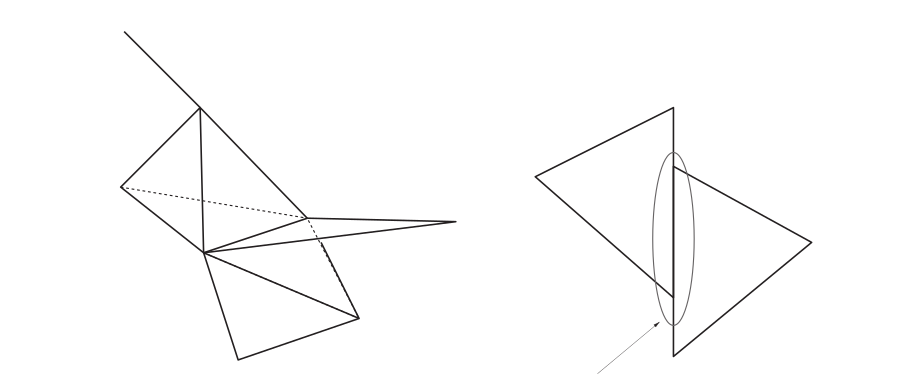

O $i$-esqueleto de um complexo é o subcomplexo formado pelos simplexos com dimensão no máximo $i$.

**Def. (Espaço do Complexo Simplicial)** Dado um complexo simplicial $K$ em $\mathbb R^d$, seu espaço
gerado é denotado por $|K| \subset \mathbb R^d$, e consiste na união dos simplícios do complexo simplicial.

Por exemplo, consire o complexo simplicial

$$
K = \{[(0,0)],[(1,0)],[(0,1)],[(0,0),(1,0)],[(0,0),(0,1)],[(1,0),(1,0)][(0,0),(1,0),(0,1)]\}.
$$

O seu espaço gerado $|K| \subset \mathbb R^2$ a região de pontos $(x,y)$ tal que $x \geq 0, y \geq 0$ e $y-x \leq 1$.




Nossa definição de complexo simplicial foi bastante "material", entretanto, existe uma maneira mais
abstrata de se referir a esse objeto.

**Def. (Complexo Simplicial Abstrato)** Dado um conjunto de pontos $V = \{v_1,...,v_n\}$, um
complexo simplicial abstrato sob $V$ é um subconjunto $\tilde K \in 2^V$ onde
* Para $i =1,...,n$ temos que $[v_i] \in \tilde K$;
* Se $\sigma \in \tilde K$ e $\tau \subset \sigma$, enetão $\tau \in \tilde K$.

Note que na nossa definição original falamos de complexos simpliciais como coleção de simplexos dados por combinações convexas,
enquanto aqui utilizamos somente os vértices para compor o complexo simplicial.
Podemos pensar na definição original como a *realização geométrica* do nosso complexo simplicial abstrato,
ou seja, são duas maneiras "equivalentes" de se referir a um complexo simplicial.

*Exemplo*. Dado $V = \{0,1,2\}$ e $\tilde K = \{[0], [1], [2], [0,1], [0,2], [1,2]\}$, temos
que de fato $\tilde K$ é um complexo simplicial abstrato, já que todos os elementos de $V$ pertencem
à $\tilde K$ e também todo subconjunto de seus elementos. E qual seria a realização geométrica?
Podemos considerar $\mathbb R^3$ e colocar os vértices $0, 1$ e $2$ nas coordernadas $(1,0,0), (0,1,0)$ e $(0,0,1)$,
respectivamente. Em seguida, consideramos os 0-simplexos (vértices) e os 1-simplexos (linhas) e os colamos.


**Objeto Topológico vs. Objeto Combinatório** 
Antes de prosseguirmos, vale dizer mais algumas palavras sobre a distinção entre o complexo simplicial abstrato e não abstrato.

Como já mencionamos, o complexo simplicial abstrato é nada mais que uma série de vértices e subconjuntos no seu power-set. Isso que dizer
que ele não tem necessariamente uma interpretação geométrica, ou seja, os complexos dados por
$\tilde K = \{[0], [1], [2], [0,1], [0,2], [1,2]\}$ e
$\tilde G = \{[a], [b], [c], [a,b], [a,c], [b,c]\}$ são isomorfos, já que podemos escrever uma bijeção levando $a \mapsto 0$, $b \mapsto 1$ e $c \mapsto 2$.

Entretanto, quando pensamos na realização geométrica, precisamos nos atentar, bem, a geometria! Ou seja,
o complexos simplicial geométrico dado pela combinação convexa dos pontos $\{(0,0),(1,0), (2,0)\}$ não representa bem
o complexo $\tilde S = \{[(0,0)], [(1,0)], [(2,0)], [(0,0),(1,0)], [(0,0),(2,0)], [(1,0),(2,0)], [(0,0),(1,0),(2,0)]\}$.
A razão disso é que o complexo abstrato representa um triângulo com arestas e face preenchida, enquanto o complexo geométrico
é na verdade só uma linha.


**Def. (Complexo Puro)** Dizmos que um complexo $K$ de dimensão $k$ é puro se todo simplexo $\sigma \in K$ for uma face
de um $k$-simplexo.

Note que por essa definição, um complexo puro é tal que para todo vértice a dimensão maximal do simplexo que é o contém será igual à $k$.
Assim, se tivermos por exemplo um complexo formado por triângulo preenchidos. Para que seja puro, ele não pode ter linhas ou vértices soltos.

Outra definição relevante é de Estrela e Link.

**Def. (Estrela e Link)** Seja $K$ um complexo e $v$ um vértice do conjunto $V$.
O conjunto Estrela$(v,K)$ é dado por todos os simplexos os quais $v$ pertence.
O Link$(v,K)$ são todos os simplexos contidos em Estrela$(v,K)$, mas que
não se conectam a $v$. Lembre que um simplexo dado por uma coleção de pontos pode ser pensado
como a combinação convexa desses ponto. Assim, faz sentido falar que o simplexo correspondente
a uma aresta de um 2-simplexo (triângulo) está contida neste 2-simplexo.

Note que uma Estrela não é um complexo. Pense no caso simples de um 2-simplexo (triângulo) e escolha um vértice qualquer, digamos $0$.
A Estrela será dada por $Star(0,K) = \{[0],[0,1], [0,2], [0,1,2]\}$. Veja que precisaríamos ter $[1], [2], [1,2]$ para que
fosse um complexo. Além disso, $[1], [2], [1,2]$ são exatamente o Link, que ao contrário da Estrela, sempre é um complexo simplicial.

**Def. (Fronteira)** Seja $K$ um complexo simplicial de dimensão $k$. A fronteira de $K$ é denotada por $\partial K$ e é o sub-complexo
de dimensão $k-1$ no qual os simplexos de dimensão $k-1$ só incidem sob uma face de dimensão $k$ no complexo $K$.

Essa definição parece confusa, mas ela captura nossa intuição do que deveria ser a fronteira.
Veja a figura abaixo, onde temos dois triângulos conectados por uma aresta. Isso define um complexo simplicial de dimensão 2.
A fronteira é então um complexo de dimensão 1, ou seja, é algum subconjunto das arestas. Veja que a aresta que conecta os triângulo
não pode pertencer a fronteira, pois ela inside sob duas faces (os dois triângulos), e portanto, a fronteira é o complexo
formado pelas demais arestas.

![imagem](boundarysimplex.svg)

O complexo simplicial é o objeto que usaremos para criar nossas malhas. Com isso, podemos agorar amarrar a definição de complexo simplicial e Manilfolds.

**Def (Manifold Combinatório)** Um complexo simplicial $K$ é um $k$-Manifold combinatório se:
* $K$ é um complexo simplicial puro de dimensão $k$;
* Para todo vértice $v \in K \setminus \partial K$, o $Link(v,K)$ é homeomorfo a uma $k-1$-esfera;
* Para todo vértice $v \in \partial K$, o $Link(v,K)$ é homeomorfo a uma $k-1$-bola.

Novamente, essa definição parece estranha, mas captura o que intuitivamente queremos. Vamos ilustrar novamente com um exemplo. 
Na figura abaixo, temos um 2-manifold combinatório formado pela junção de vários triângulos onde somente um vértice não pertence à fronteira (borda),
que é o vértice central. Vemos que o Link desse vértice é justamente um círculo, ou seja, uma 1-esfera. Já o Link de um vérice na borda
é somente uma linha, ou seja, um intervalo em $\mathbb R$, que equivale a uma 1-bola.

![combinatorialmanifold](combinatorialmanifold.svg)


**Def (Triangulação de Pontos)** A triangulação de um conjunto de pontos $P \in \mathbb R^d$ é o complexo simplicial geométrico $K$
formado pela combinação convexa desses pontos, onde os pontos $P$ definem vértices do complexo simplicial.

**Def (Triangulação de Espaço Topológico)** Dado um espaço topológico $X$, a triangulação de $X$ é uma tupla
$(K,\phi)$ onde $K$ é um complexo simplicial e $\phi:|K|\to X$ é um homeomorfismo.

## 1.5 - Orientando Simplícios
Antes de começarmos a de fato trabalhar com malhas, precisamos estabelecer o conceito de
orientação. Se você já fez algum tipo de modelagem com malha, sabe que esse é um ponto crucial, pois uma malha
com orientação incorreta pode ser desastroso na hora de computar um modelo numérico.

**Def. (Orientação de Simplexo)** Um d-simplexo orientado é um conjunto ordenado $[p_1,..., p_d]$ independentes afim, onde
duas ordenações $[p_1,...,p_d]$ e $[p_{i_1},...,p_{i_d}]$ são equivalentes se o número de permutações para ir de uma ordem
para outra for par.

Considere um triângulo formado por $[p_1,p_2,p_3]$. A sua orientação é ilustrada na figura abaixo. Note que se permutamos a ordem
dos vértices uma quantidade ímpar, mudamos a sua orietação, porém, ela se preserva se o número de permutações for par.

![orientation](orientationsimplex.svg)

**Def. (Orientação de Manifold Combinatório)** Um k-manifold combinatório $\mathcal K$ é orientável
se existir uma função que orienta seus k-simplícios tal que os simplícios compartilhando uma (k-1)-face
induzem orientações opostas nessa face.

Note que, por exemplo, num triângulo $[p_1,p_2, p_3]$, a orientação nas 1-faces é dada removendo um vértice, ou seja,
$[p_1,p_3]$ é a orientação da face oposta ao vértice $p_2$ e assim por diante.

A idéia da definição da orientação no manifold combinatório é ilustrada na figura abaixo, onde temos um 2-manifold combinatório
formado pela união de dois 2-simplícios. Note que se orientamos ambos simplícios no sentido anti-horário
obtemos justamente que a aresta $[p_1,p_3]$ tem sentido oposto em cada um dos simplícios, que é justamente o que nossa
definição exige. O que prova que o exemplo da figura é orientável.


![orientationmanifoldcomb](orientationmanifoldcomb.svg)

## 1.6 - Estrutura da Dados para Malhas Triangulares

Agora que já formalizamos a idéia de uma malha triangular (através do manifold combinatório), vamos falar um pouco de como
essa informação é normalmente estruturada para que possamos de fato utilizar essas malhas no computador.
Um dos mais comuns tipos de arquivo de malhas triangulares é o *.obj*. Nesse tipo de arquivo, temos linhas
especificando vértices, e outras especificando faces, e.g.
```
v 0.0 1.0
v 0.0 0.0
v 1.0 0.0
v 1.0 1.0
...
f 1 2 3
f 1 3 4 
```
Nesse exemplo, temos quatro vértices e duas faces.

O formato mais simples é o chamado "sopa de triângulos", no qual simplesmente se coloca os vértices de cada triângulo por linha, e.g.
```
0.0 1.0 \ 0.0 0.0 \ 1.0 0.0
0.0 1.0 \ 1.0 0.0 \ 1.0 1.0
```
Aqui estamos representando o mesmo triângulo que no exemplo do *.obj*. Nesse caso, não há nenhum tipo de informção topológica,
ou seja, se triângulo compartilham vértices ou arestas.

## 1.7 - Geodésicas, Espaço Tangente, Mapa Exponencial

Geodésicas extendem a idéia de "linha" em manifolds. Dados dois pontos $p_1, p_2 \in \mathcal M$, a pergunta que se
faz é qual a menor curva que une esses dois pontos. No espaço Euclidiano a resposta é simples, é uma linha. Em um manifold,
o nome desse menor caminho é a geodésica. Como podemos formalizar essa idéia? Para tal, parametrizamos a curva entre
os pontos $p_1$ e $p_2$ de forma que $\omega:[0,1] \to \mathcal M$ é tal que $\omega(0) = p_1$ e $\omega(1) = p_2$.

**Def**: Seja $(X,d)$ um espaço métrico. Então, a curva em $(X,d)$
é uma função contínua $\omega:[a,b] \to X$ (e.g. $[a,b] = [0,1]$).

**Def (Derivada Métrica)**:
Para uma curva $\omega:[0,1] \to X$, a derivada métrica de 
$\omega$ no tempo $t$, denotada por $|\omega'|(t)$, é

$$
|\omega'|(t) := \lim_{h \to 0} \frac{d(\omega(t+h),\omega(t))}{|h|}
$$

**Def (Continuidade Absoluta)**: A curva $\omega:[0,1] \to X$ é dita ser
absolutamente contínua se existir $g \in L^1([0,1])$ tal que

$$
d(\omega(t_0),\omega(t_1)) \leq \int^{t_1}_{t_0}g(s) ds
$$
para todo $t_0 < t_1$.
O conjunto de todas as curvas absolutamente contínuas em $[0,1]$ e valores em
$X$ é denotada por $\text{AC}(X)$.

**Def**: Dada a curva $\omega:[0,1] \to X$, definimos
$$
\text{Length}(\omega) := \sup \left\{
    \sum^{n-1}_{k=0} d(\omega(t_k),\omega(t_k+1)): n\geq 1,
    0 = t_0 < t_1 < ... < t_n = 1
\right\}.
$$

**Proposição**: Para toda curva $\omega \in \text{AC}(X)$, temos
$$
\text{Length}(\omega) = \int^1_0 |\omega'|(t) dt.
$$


**Def (Geodésica)**: A curva $\omega:[0,1] \to X$ é
chamada de geodésica entre $x \in X$ e $y \in x$ se ela é a curva com menor
comprimento dentre todas as curvas absolutamente contínuas onde
$\omega(0) = x$ e $\omega(1) = y$.

**Def (Length Sapce)**: Um espaço métrico $(X,d)$
é chamado de *length space* se

$$
d(x,y) =\inf \{ \text{Length}(\omega) : \omega \in \text{AC}(X), \omega(0) = x,\omega(1) = 1 \}.
$$

**Def (Espaço Geodésico)**: Um espaço métrico $(X,d)$ é chamado de geodésio se

$$
d(x,y) =\min \{ \text{Length}(\omega) : \omega \in \text{AC}(X), \omega(0) = x,\omega(1) = 1 \},
$$
i.e., é um *length space* onde existem geodésicas entre todo par de pontos.

**Def (Geodésica de Velocidade Constante)**:
Em um *length space*, a curva
$\omega:[0,1] \to X$ é dita ser uma geodésica de velocidade constante entre $x= \omega(0)$
e $y= \omega(1)$ se ela satisfaz

$$
d(\omega(t),\omega(s) ) = |t-s| d(\omega(0),\omega(1)), \quad
\forall t,s \in [0,1].
$$

Pode-se provar que toda curva com essa propriedade é de fato uma geodésica.

Outro conceito necessário é o de mapa exponencial em um Manifold. Tome um ponto $p\in \mathcal M$ e um vetor $\mathbf x \in T_p\mathcal M$, i.e.
um vetor tangente ao manifold no ponto $p$. Para tal condição, pode-se afirmar que existe localmente uma geodésica única
com $\omega_{\mathbf x}(0) = p$. O mapa exponencial é uma função $exp_p:T_p\mathcal M \to \mathcal M$ que retorna um novo ponto
$\omega_{\mathbf x}(1) = q \in \mathcal M$.

# 2 - Manifolds em Julia

Vamos agora finalmente entrar na parte prática. Como trabalhar com manifolds em Julia. Para isso, usaremos três pacotes
chamados Manifolds.jl, ManifoldsBase.jl e Manopt.jl. O primeiro contém uma coleção de manifolds já implementados, enquanto o segundo
provê a interface básica para criação de novos manifolds. Por fim, o terceiro é utilizado para resolver problemas de otimização em manifolds.
Isso é muito útil para tarefas como computar médias em manifolds, pois isso é feito por meio de um problema de otimização.

Os exemplos dessa seção são baseados no artigo [Manifolds.jl: An Extensible Julia Framework for Data
Analysis on Manifolds](https://arxiv.org/pdf/2106.08777.pdf).

## 2.1 Operando em um Manifold

Para mostrar algumas as funcionalidades do pacote, vamos fazer um exemplo simples de computar
um PCA numa nuvem de pontos vivendo sobre uma esfera em 3D. Isso nos ajudará a cobrir algumas
das operações básicas, como definir nosso manifold, computar o mapa logaritmo,
projetar dados, e mais.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using Manopt, Manifolds, ManifoldsBase
using Random
using MultivariateStats

  Activating project at `~/MEGA/EMAP/Modelagem-Matematica-Julia/Notebooks/Manifolds`
┌ Warning: The active manifest file has dependencies that were resolved with a different julia version (1.7.2). Unexpected behavior may occur.
└ @ nothing /home/davibarreira/MEGA/EMAP/Modelagem-Matematica-Julia/Notebooks/Manifolds/Manifest.toml:0
Precompiling project...
  ✓ RecipesBase
  ✓ RecursiveArrayTools
  ✓ Meshes
  ✓ Manifolds
  ✓ MeshViz
  5 dependencies successfully precompiled in 90 seconds. 204 already precompiled.
┌ Info: Precompiling Manifolds [1cead3c2-87b3-11e9-0ccd-23c62b72b94e]
└ @ Base loading.jl:1662


Vamos começar definindo uma esfera de dimensão dois.

In [2]:
M = Manifolds.Sphere(2)

Sphere(2, ℝ)

O objeto `M` é somente um `struct` to tipo Manifold com subtipo `Sphere(2,real)`. Ele não possui
nenhum atributo específico. A sua utilidade está no dispacho múltiplo. Ele serve como um "placeholder"
para que se possa computar a correta geodésica e outras funções.

In [3]:
γ = shortest_geodesic(M, [0., 0., 1.], [0., 1., 0.])
γ(0), γ(0.5), γ(1)

([0.0, 0.0, 1.0], [0.0, 0.7071067811865475, 0.7071067811865476], [0.0, 1.0, 6.123233995736766e-17])

Suponha que nossos dados estejam sobre uma esfera,
e queremos realizar computar o ponto médio desses pontos no nosso manifold.

Dada uma série de observações $\mathbf x$, a média normalmente se computa como $\sum^n_{i=1}\frac{x_i}{n}$. Porém,
essa fórmula é válida em um espaço Euclidiano, e não no nosso manifold. A idéia de média pode ser generalizada
como

$$
\bar x = \arg \min_{y \in \mathcal M} \sum^n_{i=1} d_\mathcal M(x_i, y)
$$

Vamos gerar nossos dados sinteticamente. Assim, o primeiro desafio é como amostrar pontos no nosso manifold.

In [4]:
using Thebes, Luxor
import Meshes
using Distributions
using Colors, ColorSchemes

┌ Info: Precompiling Thebes [8b424ff8-82f5-59a4-86a6-de3761897198]
└ @ Base loading.jl:1662
┌ Info: Precompiling Meshes [eacbb407-ea5a-433e-ab97-5258b1ca43fa]
└ @ Base loading.jl:1662


In [5]:
function drawsphere(zoomscale=100)
    
    S = Meshes.Sphere((0.,0.,0.), 1.)
    Smesh = Meshes.discretize(S, Meshes.RegularDiscretization(30,30));
    @layer begin
        vertices = [Point3D(p.coords) for p in Smesh.points]
        faces = [[f.indices...] for f in Smesh.topology.connec];
        sphere = make((vertices,faces))

        setline(0.5)
        scaleby!(sphere, zoomscale, zoomscale, zoomscale)
        pin(sphere)
    end
end

drawsphere (generic function with 2 methods)

In [6]:
n = 200
# s = reshape(hcat([random_point(M) for i in 1:n]...),n,3); # Para transformar em matri
s = [Point3D(random_point(M)) for i in 1:n];

O código acima amostra pontos com uma distribuição uniforme sobre o manifold. No nosso caso, queremos somente
pontos em uma certa seção. Vamos então utilizar outra função para gerar nossa amostra.
Para isso, vamos amostrar de uma Normal Multivariada e projetar os dados no manifold.

In [7]:
n = 400
Random.seed!(42)

μ = [1.5,0.5,0.8]
Σ = 0.6 * [0.1 -0.06 0.0;
     -0.06 0.1 0.07;
     0.0 0.07 0.1]

# data = [exp(M, x, random_tangent(M, x, Val(:Gaussian), σ)) for i in 1:n];
v = rand(MvNormal(μ,Σ),n)
v = [ManifoldsBase.project(M,i) for i in eachcol(v)]
m = mean(M,v);

Vamos visualizar nosso manifold e os dados utilizando o pacote Thebes.jl,
que é um wrapper sobre o pacote Luxor.jl para fazer desenhos em 3D.

In [8]:
function lighten(col::Colorant, f)
    c = convert(RGB, col)
    return RGB(f * c.r, f* c.g, f * c.b)
end

function drawobject(o;
        color=colorant"red")
    setlinejoin("bevel")
    
    if !isempty(o.faces)
        @layer begin
            for (n, f) in enumerate(o.faces)
                vs = o.vertices[f]
                sn = surfacenormal(vs)
                ang = anglebetweenvectors(sn, eyepoint())
                sl = slope(O, vs[1])
                pin(vs, gfunction = (p3, p2) -> begin
                    sethue(lighten(color, rescale(ang, π, 0, 0, 2)))
                    setopacity(0.8)
                    poly(p2, :fill)
                    sethue("grey30")
                    poly(p2, :stroke)
                end)
            end
        end
    end
end

function drawsphere(size, origin, color)
    S = Meshes.Sphere((0.,0.,0.), 1.)
    Smesh = Meshes.discretize(S, Meshes.RegularDiscretization(30,30));
    vertices = [Point3D(p.coords) for p in Smesh.points]
    faces = [[f.indices...] for f in Smesh.topology.connec];
    s1 = make((vertices,faces))
    
    scaleby!(s1, size, size, size)
    setline(0.5)
    moveby!(s1, origin)
    sortfaces!(s1)
    drawobject(s1, color=color)
end


drawsphere (generic function with 3 methods)

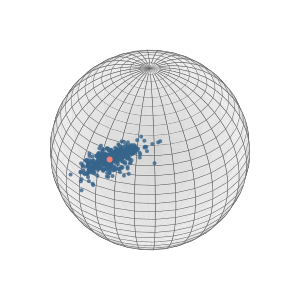

In [9]:
d = Drawing(300,300,:svg)
Luxor.origin()
eyepoint(200,200,200)
drawsphere(100, Point3D(0, 0, 0),colorant"lightgray")
p = 100Point3D.(v)
pin.(p, gfunction = (_, pt) -> begin
    sethue(colorant"steelblue4")
    setopacity(0.8)
    circle(pt, 2, :fill)
    end)

pm = 100Point3D(m)
pin(pm, gfunction = (_, pt) -> begin
    sethue(colorant"salmon")
    setopacity(1.0)
    circle(pt, 3, :fill)
    end)

finish()
d

Vamos agora computar um PCA no nosso manifold. No nosso exemplo, queremos achar a geodésica da direção com maior variabilidade.

In [10]:
logs   = log.(Ref(M),Ref(m), v)
basis  = DefaultOrthonormalBasis()

coords = map(X -> get_coordinates(M,m, X, basis), logs)
coords = reduce(hcat, coords);

No código acima, começamos computando o mapa logaritmo
da média até todos os pontos amostrados. Lembre-se que o
que o mapa logaritmo faz é retornar o vetor tangente $X$
correspondente à geodésica $\omega$ onde $\omega(0) = m$,
$\omega(1) = x$, ou seja, $\omega' = X \in T_m \mathcal M$.

In [11]:
z = zeros(manifold_dimension(M))
model = MultivariateStats.fit(PCA, coords; maxoutdim=1, mean=z)

PCA(indim = 2, outdim = 1, principalratio = 0.8988591882765024)

Pattern matrix (unstandardized loadings):
───────────
        PC1
───────────
1  0.138728
2  0.116622
───────────

Importance of components:
───────────────────────────────────
                                PC1
───────────────────────────────────
SS Loadings (Eigenvalues)  0.032846
Variance explained         0.898859
Cumulative variance        0.898859
Proportion explained       1.0
Cumulative proportion      1.0
───────────────────────────────────

Para obter o nossa direção de projeção, basta pegarmos
o valor `model.proj`.
Note que o que fizemos foi "planificar" nosso dado utilizando o mapa log, para então aplicar o PCA. Obtivemos assim um vetor em $\mathbb R^2$. Como nosso manifold na verdade é um submanifold no espaço Euclidiano 3D, queremos então transformar nosso vetor 2D em um vetor 3D.

Nós utilizamos a função
`get_vector` do pacote `Manifolds.jl` para obtermos o vetor
correspondente em $\mathbb R^3$.

In [12]:
X = get_vector(M, m, model.proj, basis)

3-element Vector{Float64}:
  0.5014512497641506
 -0.6899728479449743
 -0.5220001084374147

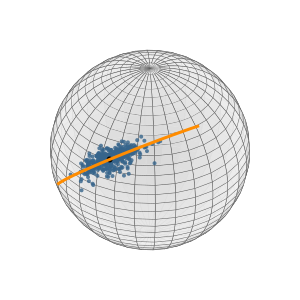

In [13]:
d = Drawing(300,300,:svg)
Luxor.origin()
eyepoint(200,200,200)
drawsphere(100, Point3D(0, 0, 0),colorant"lightgray")
p = 100Point3D.(v)
pin.(p, gfunction = (_, pt) -> begin
    sethue(colorant"steelblue4")
    setopacity(0.8)
    circle(pt, 2, :fill)
    end)

pm = 100Point3D(m)
pin(pm, gfunction = (_, pt) -> begin
    sethue(colorant"black")
    setopacity(1.0)
    circle(pt, 3, :fill)
    end)

geodesicp = Manifolds.geodesic(M, m, X,-1.0:0.1:1)
g = make([100Point3D.(geodesicp),[]],"pca")
sethue("darkorange")
setline(3)

pin(g, gfunction = (o) -> poly(objecttopoly(o)[1], :stroke))
finish()
d

In [14]:
open("manifoldplot.jl","w") do f
       # Make sure we write 64bit integer in little-endian byte order
       write(f,String(d.bufferdata))
end

412510

### 2.2 Curvas em um Manifold

Nosso segundo exemplo envolve desenhar uma curva em uma manifold. Existem infinitas maneiras de se definir
uma curva, mas utilizaremos uma específica, a chamada curva Bézier. Uma curva Bézier entre dois pontos $p, q$
é definida utilizando pontos de controle. A curva pode então ser construída como uma função paramétrica
que interpola os pontos $p$, $q$ e de controle com diferentes pesos ao longo do tempo.

In [15]:
# Bézier com um ponto de controle
B(t,p1,p2,p3) = (1-t)^2 * p1 + 2t*(1-t)*p2 + t^2*p3

B (generic function with 1 method)

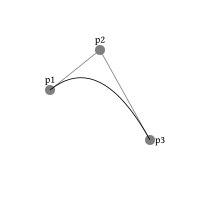

In [16]:
d = Drawing(200,200,:svg)
Luxor.origin()
pts = [Point(-50,-10),Point(0,-50),Point(50,40)]
sethue("grey")
setline(0.8)
line(pts[1],pts[2],:stroke)
line(pts[2],pts[3],:stroke)
circle.(pts,5,:fill)

sethue("black")
poly(B.(0:0.05:1,pts...),:stroke)

label("p1",:N,pts[1])
label("p2",:N,pts[2])
label("p3",:E,pts[3])
finish()
d

As duas funções a seguir computam as curvas Bézier em manifolds utilizando
a função `shortest_geodesic`. Lembre que a menor geodésica em um manifold
generaliza a idéia de linha em um espaço Euclidiano.

In [17]:
# Função para computar curvas Bézier em manifolds retirada do paper.
function bezier(M::AbstractManifold, t, pts::NTuple)
    p = bezier(M, t, pts[1:(end - 1)])
    q = bezier(M, t, pts[2:end])
    return shortest_geodesic(M, p, q, t)
end

function bezier(M::AbstractManifold, t, pts::NTuple{2})
    return shortest_geodesic(M, pts[1], pts[2], t)
end

bezier (generic function with 2 methods)

Essas duas elegantes funções acima computam as curvas de Bézier através de sua formulação recursiva. 
Sejam os pontos $p_1,...,p_n \in \mathcal M$ nossos pontos de controle, assim

$$
B_n(t,p_1,...,p_n) = B_1(t,B_{n-1}(p_1,...,p_{n-1}),B_{n-1}(t,p_2,...,p_n)),
$$

$$
B_1(t,x,y) = \omega_{x,y}(t),
$$
onde $\omega_{x,y}$ é a menor geodésica no nosso manifold tal que
$\omega_{x,y}(0) = x$ e $\omega_{x,y}(1) = y$. Logo, quando nosso manifold é um espaço Eucldiano, temos simplesmente que

$$
B_1(t,x,y) = tx + (1-t)y.
$$




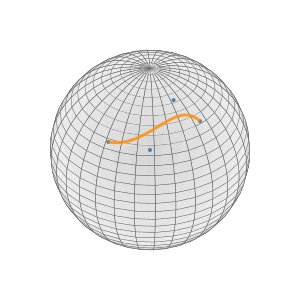

In [18]:
using LinearAlgebra

pts = [
    normalize([4,1,3]),
    normalize([1,1,1]),
    normalize([0.5,2,4]),
    normalize([0,2,2]),
]

d = Drawing(300,300,:svg)
Luxor.origin()
eyepoint(200,200,200)
drawsphere(100, Point3D(0, 0, 0),colorant"lightgray")

p = 100Point3D.(pts)
pin.(p, gfunction = (_, pt) -> begin
    sethue(colorant"steelblue4")
    setopacity(0.8)
    circle(pt, 2, :fill)
    end)

b =[100Point3D(bezier(M,t,tuple(pts...))) for t in 0:0.05:1]

g = make([b,[]],"bezier")
sethue("darkorange")
setline(3)

pin(g, gfunction = (o) -> poly(objecttopoly(o)[1], :stroke))

finish()
d

### 2.3 - Manifolds Euclidianos

In [ ]:
M = Manifolds.Euclidean(

### 2.4 - Criando Manifolds

Vamos agora entrar no ManifoldsBase.jl que lida com a parte de criar nossos próprios manifolds, invés de usar algo já implementado.

In [ ]:
"""
    MySphere{N} <: AbstractManifold{ℝ}

Define an `n`-sphere of radius `r`. Construct by `MySphere(radius,n)`
"""
struct MySphere{N} <: AbstractManifold{ManifoldsBase.ℝ} where {N}
    radius::Float64
end
MySphere(radius, n) = MySphere{n}(radius)
Base.show(io::IO, M::MySphere{n}) where {n} = print(io, "MySphere($(M.radius),$n)")

In [ ]:
S = MySphere(1.5, 2)